# EEG classification task: linear model

## 0. Preprocessing summary 

EEG preprocessing (Matlab)

All low-level preprocessing was performed in Matlab on the raw EEG recordings.  
For each session we applied the following steps:

1. **EOG artifact removal**  
   - Regress out EOG activity from the EEG channels using a linear regression model:
     \[
     \text{EEG}_\text{clean} = \text{EEG} - X_{\text{EOG}} \beta
     \]
     where \(\beta\) is estimated on a 1-minute segment with strong eye movements.

2. **Band-pass filtering (2–45 Hz)**  
   - Apply a zero-phase Butterworth filter to retain the relevant EEG frequency band.

3. **Trial alignment and artifact rejection**  
   - Use trial onset markers to identify the motor-imagery period.
   - Remove trials marked as artifacts.

4. **Amplitude thresholding in the imagery period**  
   - Within each 3 s imagery window, set samples with amplitude > 60 µV to zero.

From these cleaned continuous signals we extracted:
- **3-channel imagery segments** (C3, Cz, C4) → used directly for **deep learning** models.
- **Bandpower features** over the 3 s imagery period → used for **linear models** in this notebook.


## 1. Imports & config

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

# Scikit-learn & mlxtend
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
    roc_auc_score
)
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

%matplotlib inline
plt.style.use("ggplot")
sns.set(font_scale=1.1)

In [ ]:
# Root folder where the CSVs are stored
data_dir = Path("...") # add here your path

train_path = data_dir / "trainset_feat_new.csv"
test_path  = data_dir / "testset_feat_new.csv"

df_train = pd.read_csv(train_path)
df_test  = pd.read_csv(test_path)

df_train.head()


## 3. Class balance

label
0    201
1    198
dtype: int64


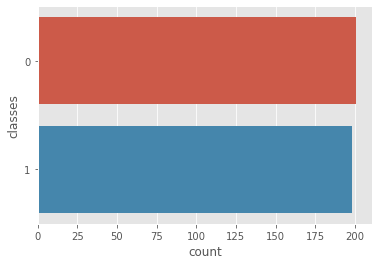

In [ ]:
# Class counts
print("Training set class counts:")
print(df_train.groupby("label").size())

plt.figure(figsize=(4, 3))
sns.countplot(x="label", data=df_train)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class distribution (train)")
plt.show()

## 4. Train/test preparation + Standard Scaling

In [ ]:
y_train = df_train["label"]
y_test  = df_test["label"]

X_train = df_train.drop(columns="label")
X_test  = df_test.drop(columns="label")

# Standardization
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

X_train_scaled.head()

,8-10_Hz_ch1,9-11_Hz_ch1,10-12_Hz_ch1,11-13_Hz_ch1,12-14_Hz_ch1,13-15_Hz_ch1,14-16_Hz_ch1,15-17_Hz_ch1,16-18_Hz_ch1,17-19_Hz_ch1,...,15-21_Hz_ch3,16-22_Hz_ch3,17-23_Hz_ch3,18-24_Hz_ch3,19-25_Hz_ch3,20-26_Hz_ch3,21-27_Hz_ch3,22-28_Hz_ch3,23-29_Hz_ch3,24-30_Hz_ch3
0,-0.218365,-0.655636,-0.747476,-0.711136,-0.360764,-0.676228,-0.795878,-0.090818,-0.299774,-0.817406,...,-0.272900,-0.535290,-0.486853,-0.280388,0.003093,-0.148007,-0.568660,-0.438926,-0.613279,-0.905374
1,-0.281592,-0.413859,0.568960,0.793063,0.980081,-0.119096,-0.708652,-0.315906,0.032473,0.734036,...,-0.356428,-0.368260,-0.427362,-0.557599,-0.502911,-0.897279,-1.328490,-1.539244,-1.517011,-1.381815
2,-0.781658,-0.797479,-0.971678,-0.961990,-0.234026,-0.782575,-0.478300,-0.774078,-0.607420,-0.712027,...,-0.221369,-0.321156,-0.327851,-0.486165,-0.222524,-0.017443,-0.868061,-1.107224,-0.240807,0.408686
3,-0.019104,0.082210,0.284406,0.599222,-0.119450,1.266924,0.795565,-0.112004,2.225228,1.486915,...,-0.967036,-1.039763,-1.106428,-1.064005,-0.880385,-0.877149,-1.185925,-1.072383,-0.829889,-0.955625
4,-0.472539,-0.261290,0.126893,0.407512,-0.323992,-0.368793,0.259785,0.605004,1.484063,0.760779,...,-0.294612,-0.374715,-0.489328,-0.430271,-0.217970,-0.419820,-0.402762,-0.818566,-0.274036,-0.644349


## 5. Feature selection

In [ ]:
from data_processing import sequ_feature_selection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


lda = LinearDiscriminantAnalysis()

X_train_fs, selected_features = sequ_feature_selection(
    estimator=lda,
    n_features=10,
    X=X_train_scaled,
    y=y_train,
    corr_based=False,
    method="SFS"
)

print("Selected features:")
for f in selected_features:
    print(" -", f)

# Apply the same feature subset to the test set
X_test_fs = X_test_scaled[selected_features]


In [17]:
with tf.device('/gpu:0'):
    estim  = LinearDiscriminantAnalysis()
    X_final, feat_selected= sequ_feature_selection(estim, n_features=10, dataset=x_train_stand,
    #X_final, feat_selected= sequ_feature_selection(estim, n_features=10, dataset=x_train, 
                                                   lab=y_train, corr_based=False, type_selection='SFS')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 171 out of 171 | elapsed:    0.1s finished

[2023-03-06 08:33:05] Features: 1/10 -- score: 0.7192982456140351[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 170 out of 170 | elapsed:    0.1s finished

[2023-03-06 08:33:05] Features: 2/10 -- score: 0.8145363408521303[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 138 out of 169 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:    0.1s finished

[2023-03-06 08:33:05] Features: 3/10 -- score: 0.8320802005012532[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jo

In [18]:
x_final_train=X_final.copy()
x_final_test=x_test_stand[feat_selected]
y_final_train=y_train.copy()
y_final_test=y_test

y_final_test

0      1
1      0
2      1
3      0
4      1
      ..
302    1
303    1
304    1
305    0
306    0
Name: label, Length: 307, dtype: int64

## 6. Model Selection

In [ ]:
from model_selection import hyperp_search

### Logistic Regression

accuracy train: 0.844612 using {}
accuracy test:  0.8436482084690554


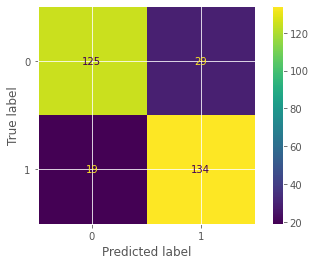

              precision    recall  f1-score   support

           0       0.87      0.81      0.84       154
           1       0.82      0.88      0.85       153

    accuracy                           0.84       307
   macro avg       0.85      0.84      0.84       307
weighted avg       0.85      0.84      0.84       307



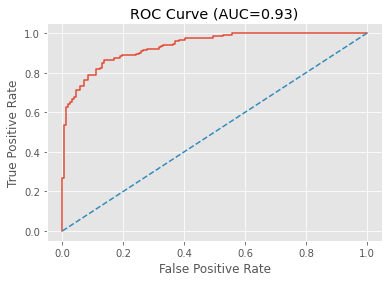

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
parameters = {}

#"C":[1,2,1e-1,5,10],'class_weight': ['balanced', 'None']

hyperp_search(model,parameters,x_final_train,y_final_train,x_final_test,y_final_test)

### Linear Discriminant Analysis

accuracy train: 0.864662 using {'solver': 'svd'}
accuracy test:  0.8664495114006515


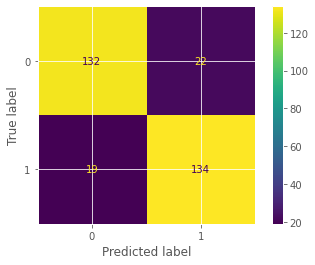

              precision    recall  f1-score   support

           0       0.87      0.86      0.87       154
           1       0.86      0.88      0.87       153

    accuracy                           0.87       307
   macro avg       0.87      0.87      0.87       307
weighted avg       0.87      0.87      0.87       307



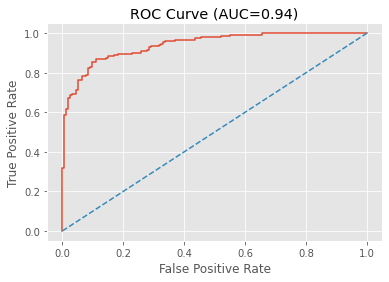

In [59]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model=LinearDiscriminantAnalysis()
parameters = {"solver": ['svd', 'lsqr', 'eigen']}


hyperp_search(model,parameters,x_final_train,y_final_train,x_final_test,y_final_test)